In [ ]:
import pandas as pd
df=pd.read_csv('/content/train_u6lujuX_CVtuZ9i.csv')
df.head()
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.metrics import roc_auc_score
import math



  







In [ ]:
#Data preprocessing
df.isnull().sum()
#df.columns
#df.dtypes
#df.shape




Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Gender                       int64
Married                      int64
Education                    int64
Self_Employed                int64
ApplicantIncome              int64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
Property_Area_Rural          uint8
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
Dependents_0                 uint8
Dependents_1                 uint8
Dependents_2                 uint8
Dependents_3                 uint8
dtype: object

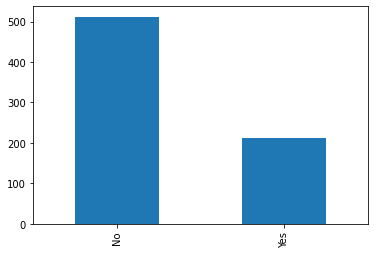

In [ ]:
df['Gender'].value_counts().plot.bar()
df['Dependents'].value_counts().plot.bar()
df['Married'].value_counts().plot.bar()
df['Credit_History'].value_counts().plot.bar()
df['Loan_Amount_Term'].value_counts().plot.bar()
df['Property_Area'].value_counts().plot.bar()
df['Self_Employed'].value_counts().plot.bar()

df['LoanAmount']=df['LoanAmount'].replace(np.NaN,df['LoanAmount'].median())
df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(np.NaN,df['Loan_Amount_Term'].median())
df['Credit_History'].fillna(df['Credit_History'].mode()[0],inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0],inplace=True)
df['Married'].fillna(df['Married'].mode()[0],inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0],inplace=True)
df.isnull().sum()


#let us replace categorical features with two categories with 0 and 1
df['Loan_Status'].replace('Y',1,inplace=True)
df['Loan_Status'].replace('N',0,inplace=True)

df['Married'].replace('Yes',1,inplace=True)
df['Married'].replace('No',0,inplace=True)

df['Gender'].replace('Male',1,inplace=True)
df['Gender'].replace('Female',0,inplace=True)

df['Education'].replace('Graduate',1,inplace=True)
df['Education'].replace('Not Graduate',0,inplace=True)

df['Self_Employed'].replace('Yes',1,inplace=True)
df['Self_Employed'].replace('No',0,inplace=True)

X=df.iloc[:,1:-1]
Y=df['Loan_Status']
X
Y
X['Dependents']=X['Dependents'].map(lambda x:x.rstrip('+'))
X
final=pd.get_dummies(X,columns=['Property_Area','Dependents'])
final.dtypes














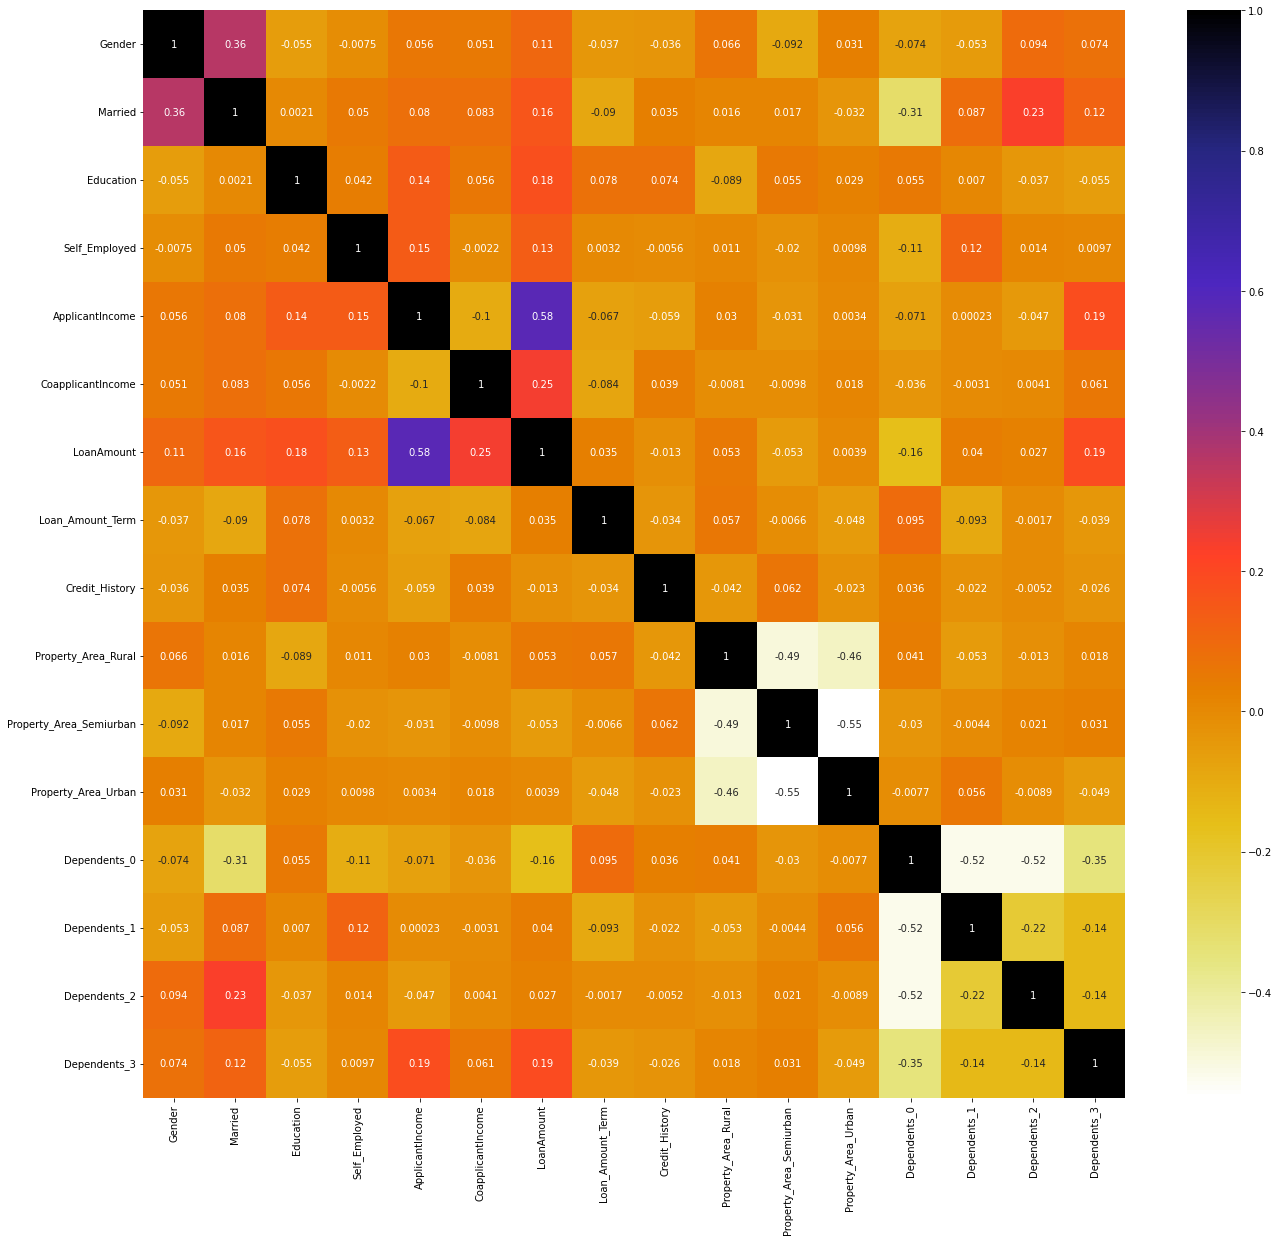

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(final, Y, test_size=0.3, random_state=0)
X_train.shape
plt.figure(figsize=(22,20))
cor=X_train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

scaler=StandardScaler()
X_train_standarized=scaler.fit_transform(X_train)
X_test_standardized=scaler.transform(X_test)







In [ ]:
def Grid_search(X_train_standarized,y_train):
  cv=KFold(n_splits=5)
  C_values=[0.001,0.01,0.1,1,10,100]
  model=LogisticRegression()
  parameters={'C':C_values}
  clf = GridSearchCV(model,parameters, cv=cv, scoring='roc_auc',return_train_score=True,verbose=1)
  clf.fit(X_train_standarized,y_train)
  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_C'])

  train_auc= clf.cv_results_['mean_train_score']
  train_auc_std= clf.cv_results_['std_train_score']
  cv_auc = clf.cv_results_['mean_test_score'] 
  cv_auc_std= clf.cv_results_['std_test_score']
  best_C= clf.best_params_['C']

  sns.set()
  C_values=[math.log(x) for x in C_values]
  plt.plot(C_values, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
  plt.gca().fill_between(C_values,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

  plt.plot(C_values, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
  plt.gca().fill_between(C_values,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
  plt.scatter(C_values, train_auc, label='Train AUC points')
  plt.scatter(C_values, cv_auc, label='CV AUC points')
  plt.legend()
  plt.xlabel("C_values: hyperparameter")
  plt.ylabel("AUC")
  plt.title("ERROR PLOTS")
  plt.show()
    
  print("Best cross-validation score: {:.3f}".format(clf.best_score_))
  print('The best C from gridsearch :',best_C)
  return  best_C



Fitting 5 folds for each of 6 candidates, totalling 30 fits


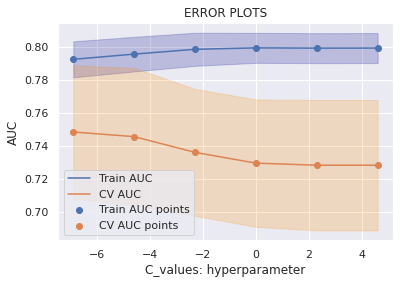

Best cross-validation score: 0.748
The best C from gridsearch : 0.001


In [ ]:
best_C=Grid_search(X_train_standarized,y_train)

In [ ]:
# function for testing the performance of test data

from sklearn.metrics import roc_curve, auc

def test_data(x_train,y_train,x_test,y_test):
    model=LogisticRegression(C=best_C)
    model.fit(x_train, y_train)
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])

    sns.set()
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0, 1], [0, 1], color='green', lw=1, linestyle='--')
    plt.legend()
    plt.xlabel("False_positive_rate")
    plt.ylabel("True positive_rate")    
    plt.title("ROC_Curve")
    plt.grid()
    plt.show()
    print('The AUC_score of test_data is :',auc(test_fpr, test_tpr))

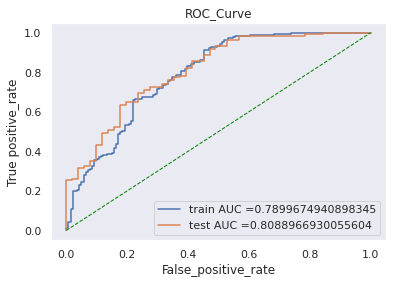

The AUC_score of test_data is : 0.8088966930055604


In [ ]:
test_data(X_train_standarized,y_train,X_test_standardized,y_test) 

In [ ]:
#Confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def metric(x_train,y_train,x_test,y_test):
    model=LogisticRegression(C=best_C)
    model.fit(x_train, y_train)
    predict=model.predict(x_test)

    conf_mat = confusion_matrix(y_test, predict)
    class_label = ["Negative", "Positive"]
    df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
    
    report=classification_report(y_test,predict)
    print(report)
    
    sns.set()
    sns.heatmap(df, annot = True,fmt="d")
    plt.title("Test_Confusion_Matrix")
    plt.xlabel("Predicted_Label")
    plt.ylabel("Actual_Label")
    plt.show()

In [ ]:
lr = LogisticRegression(C=best_C)
lr.fit(X_train_standarized,y_train)

print(lr.coef_)

[[ 0.00096474  0.01591109  0.01802538 -0.000654   -0.00094448 -0.01175724
  -0.00439415 -0.00295274  0.09891641 -0.01938939  0.02386364 -0.00581508
  -0.00245972 -0.00948865  0.00901834  0.0049321 ]]


In [ ]:
feats=final.columns
feats
coefs=lr.coef_.reshape(-1,1)
dff=pd.DataFrame(coefs,columns=['coef'],index=feats)
top_neg=dff.sort_values(ascending=True,by='coef').head(10)
top_pos=dff.sort_values(ascending=False,by='coef').head(10)
print('Top 10 Positive features')
print(top_pos)
print('-'*50)
print('Top 10 Negative features')
print(top_neg)

Top 10 Positive features
                             coef
Credit_History           0.098916
Property_Area_Semiurban  0.023864
Education                0.018025
Married                  0.015911
Dependents_2             0.009018
Dependents_3             0.004932
Gender                   0.000965
Self_Employed           -0.000654
ApplicantIncome         -0.000944
Dependents_0            -0.002460
--------------------------------------------------
Top 10 Negative features
                         coef
Property_Area_Rural -0.019389
CoapplicantIncome   -0.011757
Dependents_1        -0.009489
Property_Area_Urban -0.005815
LoanAmount          -0.004394
Loan_Amount_Term    -0.002953
Dependents_0        -0.002460
ApplicantIncome     -0.000944
Self_Employed       -0.000654
Gender               0.000965
